In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor

## Loading data

In [2]:
# Read all tables
customers = pd.read_csv('data/customers_final.csv')
engagements = pd.read_csv('data/engagements_final.csv')
marketing = pd.read_csv('data/marketing_final.csv')
transactions = pd.read_csv('data/transactions_final.csv')

In [3]:
customers.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [4]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [5]:
engagements.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [6]:
engagements.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [7]:
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [8]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [9]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [10]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


## Converting date columns to datetime

In [11]:
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

## Filling missing values

In [12]:
median_age = customers['age'].median()
mode_gender = customers['gender'].mode()[0]
customers['age'] = customers['age'].fillna(median_age)
customers['gender'] = customers['gender'].fillna(mode_gender)

## Data aggregation and consolidation into a single dataset

In [13]:
# Creating aggregate dataframes
marketing_agg = marketing[marketing['response'] == 'Yes'].groupby('customer_id')['campaign_id'].count().to_frame()
transactions_agg = transactions.groupby('customer_id').aggregate(
    {'transaction_id': 'count', 'transaction_amount': 'sum'})

# Setting indices for joining
customers.set_index('customer_id', inplace=True)
engagements.set_index('customer_id', inplace=True)

# Joining data
joint_data = customers.join(engagements).join(transactions_agg).join(marketing_agg)
joint_data['campaign_id'] = joint_data['campaign_id'].fillna(0)

joint_data.head(10)

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,44.0,Male,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,0.0
6,2022-01-01,2023-02-10,55.0,Female,North Richardfort,74,59,7,17,10254.44,1.0
7,2023-12-11,2024-05-29,44.0,Female,Perezside,64,4,6,5,1339.82,1.0
8,2023-02-09,2023-08-09,68.0,Male,Marquezton,60,22,7,15,11710.62,2.0
9,2022-01-24,2023-08-15,68.0,Female,West Franciscobury,49,43,21,22,10382.96,1.0


# Feature engineering

In [14]:
# Calculating customer tenure in the company in days
joint_data['customer_tenure'] = (pd.Timestamp('today') - pd.to_datetime(joint_data['join_date'])).dt.days

# Calculating the average time between purchases for each customer
transactions['days_between_purchases'] = transactions.sort_values(
    ['customer_id', 'transaction_date']).groupby('customer_id')['transaction_date'].diff().dt.days
avg_days_between_purchases = transactions.groupby('customer_id')['days_between_purchases'].mean()
joint_data = joint_data.join(avg_days_between_purchases.rename('avg_days_between_purchases'), on='customer_id')

# Handling missing values in 'avg_days_between_purchases' by filling with median
median_days = joint_data['avg_days_between_purchases'].median()
joint_data['avg_days_between_purchases'] = joint_data['avg_days_between_purchases'].fillna(median_days)

# Count the number of marketing campaigns each customer has participated in
num_marketing_campaigns = marketing.groupby('customer_id').size()
joint_data['num_marketing_campaigns'] = joint_data.index.map(num_marketing_campaigns).fillna(0)

# Calculating the number of days since the last purchase
joint_data['days_since_last_purchase'] = (pd.Timestamp('today') - joint_data['last_purchase_date']).dt.days

# Calculate the response rate to marketing campaigns for each customer
marketing['response_binary'] = marketing['response'].apply(lambda x: 1 if x == 'Yes' else 0)
marketing_response_rate = marketing.groupby('customer_id')['response_binary'].mean()
joint_data['marketing_response_rate'] = joint_data.index.map(marketing_response_rate).fillna(0)

joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,customer_tenure,avg_days_between_purchases,num_marketing_campaigns,days_since_last_purchase,marketing_response_rate
customer_id,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,236,12.600000,4,118,0.25
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,2.0,1039,64.375000,4,262,0.50
3,2021-06-01,2022-11-27,44.0,Male,North Latoyatown,192,73,25,6,1454.87,1.0,1138,83.200000,2,594,0.50
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,924,12.210526,4,681,0.25
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,0.0,901,19.826087,4,407,0.00


## LTV calculation

In [15]:
# Calculate the average revenue per purchase
joint_data['avg_revenue_per_purchase'] = joint_data['transaction_amount'] / joint_data['transaction_id']

# Calculate the purchase frequency
joint_data['purchase_frequency'] = joint_data['transaction_id'] / joint_data['customer_tenure']

# Calculate LTV using average revenue per purchase and purchase frequency
joint_data['LTV'] = joint_data['avg_revenue_per_purchase'] * joint_data['purchase_frequency'] * joint_data['customer_tenure']

# Display the updated DataFrame with the LTV column
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,customer_tenure,avg_days_between_purchases,num_marketing_campaigns,days_since_last_purchase,marketing_response_rate,avg_revenue_per_purchase,purchase_frequency,LTV
customer_id,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0,236,12.600000,4,118,0.25,584.913333,0.025424,3509.48
2,2021-09-08,2023-10-25,44.0,Male,Hillville,285,49,51,9,6081.32,2.0,1039,64.375000,4,262,0.50,675.702222,0.008662,6081.32
3,2021-06-01,2022-11-27,44.0,Male,North Latoyatown,192,73,25,6,1454.87,1.0,1138,83.200000,2,594,0.50,242.478333,0.005272,1454.87
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0,924,12.210526,4,681,0.25,393.734000,0.021645,7874.68
5,2022-01-24,2023-06-02,44.0,Male,East Matthewfort,161,2,7,24,15524.55,0.0,901,19.826087,4,407,0.00,646.856250,0.026637,15524.55


## Coding of categorical variables

In [16]:
# Apply OneHot encoding to 'gender'
onehot_encoder = OneHotEncoder(sparse_output=False)
gender_encoded = onehot_encoder.fit_transform(joint_data[['gender']])

# Convert to DataFrame
gender_encoded_df = pd.DataFrame(gender_encoded, columns=onehot_encoder.get_feature_names_out(['gender']), index=joint_data.index)

# Join the encoded gender data back to the main DataFrame
joint_data_encoded = joint_data.join(gender_encoded_df)

# Drop unneeded columns
columns_to_drop = ['location', 'gender', 'gender_Female', 'join_date', 'last_purchase_date']
joint_data_encoded.drop(columns_to_drop, axis=1, inplace=True)

# Display the head of the updated DataFrame
joint_data_encoded.head()

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,customer_tenure,avg_days_between_purchases,num_marketing_campaigns,days_since_last_purchase,marketing_response_rate,avg_revenue_per_purchase,purchase_frequency,LTV,gender_Male
customer_id,,,,,,,,,,,,,,,,
1,56.0,10,15,1,6,3509.48,1.0,236,12.600000,4,118,0.25,584.913333,0.025424,3509.48,0.0
2,44.0,285,49,51,9,6081.32,2.0,1039,64.375000,4,262,0.50,675.702222,0.008662,6081.32,1.0
3,44.0,192,73,25,6,1454.87,1.0,1138,83.200000,2,594,0.50,242.478333,0.005272,1454.87,1.0
4,29.0,110,30,17,20,7874.68,1.0,924,12.210526,4,681,0.25,393.734000,0.021645,7874.68,1.0
5,44.0,161,2,7,24,15524.55,0.0,901,19.826087,4,407,0.00,646.856250,0.026637,15524.55,1.0


## Calculate the correlation matrix

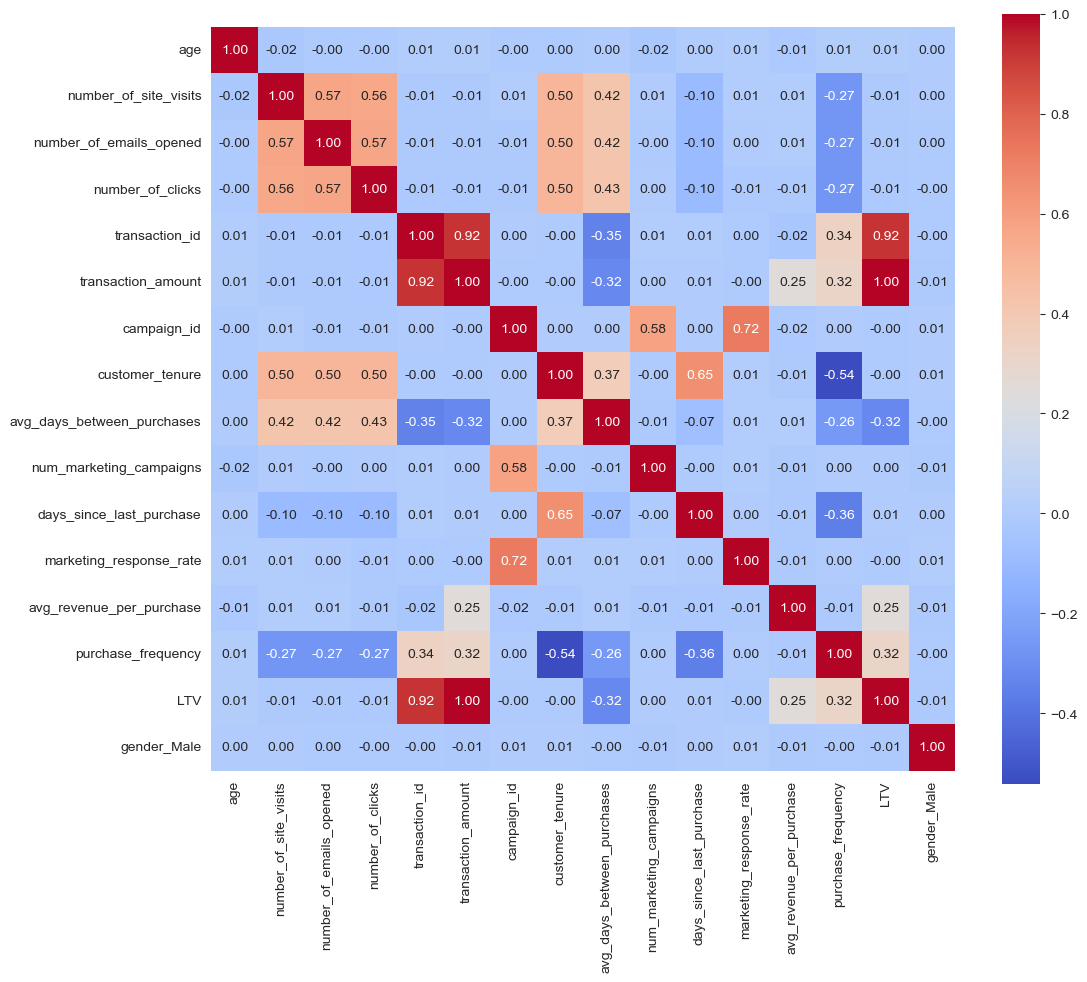

In [17]:
correlation_matrix = joint_data_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Display the heatmap
plt.show()

## Scaling of numeric features using MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scale_columns = ['age', 'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks',
                 'transaction_amount', 'LTV', 'customer_tenure', 'avg_days_between_purchases',
                 'num_marketing_campaigns', 'marketing_response_rate', 'days_since_last_purchase', 'avg_revenue_per_purchase']

# Apply scaling to selected columns
joint_data_encoded[scale_columns] = scaler.fit_transform(joint_data_encoded[scale_columns])

joint_data_encoded.head()

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,customer_tenure,avg_days_between_purchases,num_marketing_campaigns,days_since_last_purchase,marketing_response_rate,avg_revenue_per_purchase,purchase_frequency,LTV,gender_Male
customer_id,,,,,,,,,,,,,,,,
1,0.745098,0.012676,0.046358,0.000000,6,0.143594,1.0,0.119727,0.010169,1.000000,0.047259,0.25,0.284352,0.025424,0.143594,0.0
2,0.509804,0.400000,0.158940,0.354610,9,0.249543,2.0,0.617866,0.051957,1.000000,0.137996,0.50,0.330361,0.008662,0.249543,1.0
3,0.509804,0.269014,0.238411,0.170213,6,0.058953,1.0,0.679280,0.067151,0.333333,0.347196,0.50,0.110815,0.005272,0.058953,1.0
4,0.215686,0.153521,0.096026,0.113475,20,0.323422,1.0,0.546526,0.009855,1.000000,0.402016,0.25,0.187468,0.021645,0.323422,1.0
5,0.509804,0.225352,0.003311,0.042553,24,0.638563,0.0,0.532258,0.016002,1.000000,0.229364,0.00,0.315743,0.026637,0.638563,1.0


## Define the target variable and features

In [19]:
X = joint_data_encoded.drop(columns=['LTV', 'transaction_amount', 'transaction_id'])
y = joint_data_encoded['LTV']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model initialization and training

In [20]:
# Initialize models
linear_reg = LinearRegression()
rfr = RandomForestRegressor()
xgb = XGBRegressor()

# Train models
linear_reg.fit(X_train, y_train)
rfr.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## # Model prediction and evaluation

In [21]:
# Prediction and evaluation of models
models = {
    'Linear Regression': linear_reg,
    'Random Forest Regressor': rfr,
    'XGBoost Regressor': xgb
}

results = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R2': r2}

# Formation of results
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest Regression', 'XGBoost Regression'],
    'MSE (Mean Square Error)': [
        f'{results["Linear Regression"]["MSE"]:.8f}',
        f'{results["Random Forest Regressor"]["MSE"]:.8f}',
        f'{results["XGBoost Regressor"]["MSE"]:.8f}'
    ],
    'R2 (Coefficient of Determination)': [
        f'{results["Linear Regression"]["R2"]:.4f}',
        f'{results["Random Forest Regressor"]["R2"]:.4f}',
        f'{results["XGBoost Regressor"]["R2"]:.4f}'
    ]
})

# Display results
results_df

,Model,MSE (Mean Square Error),R2 (Coefficient of Determination)
0,Linear Regression,0.02341158,0.3341
1,Random Forest Regression,0.00042037,0.9880
2,XGBoost Regression,0.00036758,0.9895


## Displaying the importance of features

In [22]:
# Display feature importances for each model
def display_feature_importances(model, model_name):
    if hasattr(model, 'coef_'):
        importance = model.coef_
    else:
        importance = model.feature_importances_
    
    features = X_train.columns
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
    
    print(f'Importance of features for the model {model_name}')
    print(importance_df)

# Display feature importances for each model
for model_name, model in models.items():
    display_feature_importances(model, model_name)

Importance of features for the model Linear Regression
                       Feature  Importance
11          purchase_frequency    1.604689
10    avg_revenue_per_purchase    0.513598
5              customer_tenure    0.344473
2      number_of_emails_opened    0.006318
9      marketing_response_rate    0.005473
7      num_marketing_campaigns    0.004433
0                          age    0.004124
4                  campaign_id   -0.001905
12                 gender_Male   -0.003554
3             number_of_clicks   -0.003708
1        number_of_site_visits   -0.020765
8     days_since_last_purchase   -0.191395
6   avg_days_between_purchases   -1.651277
Importance of features for the model Random Forest Regressor
                       Feature  Importance
11          purchase_frequency    0.622620
10    avg_revenue_per_purchase    0.196412
5              customer_tenure    0.167843
8     days_since_last_purchase    0.002190
0                          age    0.002079
6   avg_days_between_pur